

## **Loading Dataset from Drive**

In [1]:
import os
import pandas as pd
import numpy as np


import cv2

In [ ]:
!pip3 install  --user torch===1.5.1 torchvision===0.6.1 -f https://download.pytorch.org/whl/torch_stable.html



In [38]:
!pip3 install --user scikit-image

  Using cached https://files.pythonhosted.org/packages/09/e2/39fd2aad9858c764bc260acdf4bb63f8096415ee2b782cc2f7ea47a12c79/scikit_image-0.17.2-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/30/9f/60c3b80bcefc7e3cbc76c0925e05159312cae0f3e8bf822cf50ba30b5312/PyWavelets-1.1.1-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/b4/56/6df3882f6b2032b5132e83543776a5da5a395b0a403adba2100a4ed0c2c6/tifffile-2020.7.24-py3-none-any.whl
  Found existing installation: pywavelets 1.0.3
    Uninstalling pywavelets-1.0.3:
      Successfully uninstalled pywavelets-1.0.3


  The scripts lsm2bin.exe and tifffile.exe are installed in 'C:\Users\Shaheryar\AppData\Roaming\Python\Python36\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  The script skivi.exe is installed in 'C:\Users\Shaheryar\AppData\Roaming\Python\Python36\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import Resize,ToTensor,Normalize,RandomRotation,RandomHorizontalFlip
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
import time
import os
from skimage import io
import copy
from torch import optim, cuda
# Useful for examining network
from torchsummary import summary

In [40]:

from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Image manipulations
from PIL import Image

# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 10

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [84]:

CLASSES=['400G STRAWBERRIES','LARGE EGGS 10PK','SEMI SKIMMED MILK']

base_dir = r'C:\Users\Shaheryar\PycharmProjects\Store Wide Active Intelligence\Totally Cleaned and Labelled Dataset\Killburn'

NUM_CLASSES=len(CLASSES)
NUM_CLASSES

3

In [85]:
data_transform=transforms.Compose([
        Resize((224,224)),
        RandomHorizontalFlip(p=0.5),
        # RandomRotation((-40,40)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [86]:
INPUT_SIZE = (224,224)

In [87]:
dataset= datasets.ImageFolder(base_dir,transform=data_transform)


In [88]:
print(dataset)


Dataset ImageFolder
    Number of datapoints: 3317
    Root location: C:\Users\Shaheryar\PycharmProjects\Store Wide Active Intelligence\Totally Cleaned and Labelled Dataset\Killburn
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )



### **Dataset Analysis**



Analysis of the data
LARGE EGGS 10PK      1884
400G STRAWBERRIES     814
SEMI SKIMMED MILK     619
Name: label, dtype: int64


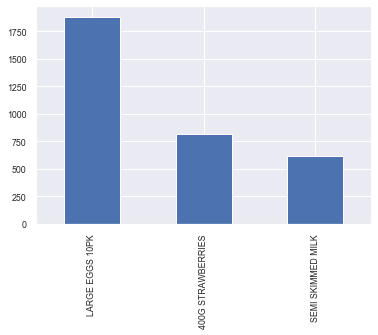

In [89]:
def loadDataset(path):
    dir = os.listdir(path)
    X=[];
    y=[];

    for class_name in CLASSES:

        files =os.listdir(os.path.join(path,class_name))
        for f in files:
            X.append(os.path.join(path,class_name,f))
            y.append(class_name)        
    return pd.DataFrame({"path":X,"label":y})
df=loadDataset(base_dir)
print("Analysis of the data")
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar')

***Test Train Split***





In [118]:
# Spliting data into 80% train 20% validation
validation_split = .10
shuffle_dataset = False
random_seed= 42
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

**Making test and validation data loaders**

In [119]:
batch_size=8

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader =DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [120]:
len(validation_loader.sampler)

331

**Visualize Sample Images**

torch.Size([8, 3, 224, 224])
[1 1 1 2 1 2 0 1]


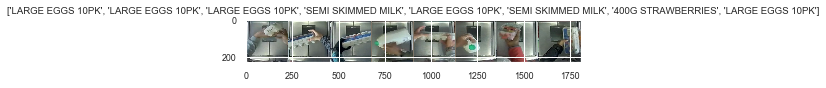

In [121]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
print(inputs.shape)
print(classes.numpy())
imshow(out, title=[CLASSES[x] for x in classes])


# **Fine Tuning Pretrained**

In [122]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


Train on gpu: True
1 gpus detected.


In [123]:
def get_pretrained_model():
    """Retrieve a pre-trained model from torchvision

    Return
    --------
        model (PyTorch model): cnn

    """

    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
#         nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
        nn.Linear(n_inputs, NUM_CLASSES), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    

    return model

In [124]:
model = get_pretrained_model()

**Check count of Trainable and Non-Trainable Parameters**

In [125]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,514,179 total parameters.
6,147 training parameters.


In [126]:
# Move to gpu
model = model.to('cuda')

**Print Model summary**

In [127]:
from torchsummary import summary

summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]           4,096
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
           Conv2d-11           [8, 256, 56, 56]          16,384
      BatchNorm2d-12           [8, 256, 56, 56]             512
           Conv2d-13           [8, 256, 56, 56]          16,384
      BatchNorm2d-14           [8, 256,

In [128]:

model.class_to_idx = dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}
list(model.idx_to_class.items())

[(0, '400G STRAWBERRIES'), (1, 'LARGE EGGS 10PK'), (2, 'SEMI SKIMMED MILK')]

## Training Network

In [129]:
save_file_name = 'resnet50-transfer.pt'
checkpoint_path = 'resnet50-transfer.pth'



def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=5,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
        running_corrects=0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
      
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                running_corrects += torch.sum(pred == target.data)

                # print(running_corrects,len(valid_loader.dataset))


                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.sampler)
            valid_loss = valid_loss / len(valid_loader.sampler)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.sampler)
            valid_acc = valid_acc / len(valid_loader.sampler)
            epoch_acc = running_corrects.double() / len(valid_loader.sampler)
            

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                # print("epoch_acc",epoch_acc)
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    print("\n\n----------------\n\n")
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [130]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters())
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [131]:

model, history = train(
    model,
    criterion,
    optimizer_ft,
    train_loader,
    validation_loader,
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=15,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 18.99 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.4614 	Validation Loss: 0.8302
		Training Accuracy: 83.42%	 Validation Accuracy: 61.03%
Epoch: 1	100.00% complete. 18.82 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2695 	Validation Loss: 0.5847
		Training Accuracy: 90.52%	 Validation Accuracy: 74.32%
Epoch: 2	100.00% complete. 18.95 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2129 	Validation Loss: 0.6707
		Training Accuracy: 92.67%	 Validation Accuracy: 69.18%
Epoch: 3	100.00% complete. 18.89 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1828 	Validation Loss: 0.6906
		Training Accuracy: 94.04%	 Validation Accuracy: 72.21%
Epoch: 4	100.00% complete. 18.67 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.1701 	Validation Loss: 0.3099
		Training Accuracy: 94.47%	 Validation Accuracy: 88.82%
Epoch: 5	100.00% complete. 18.58 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1569 	Validation

**Results**

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

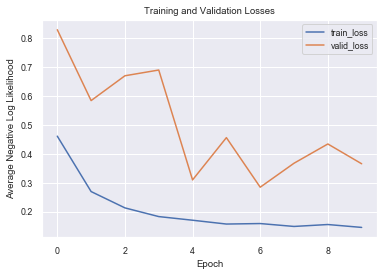

In [132]:
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

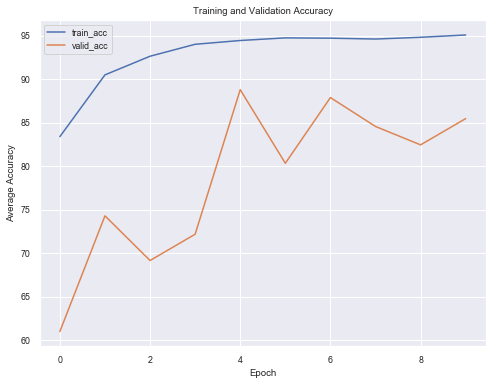

In [133]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

## **Inference section**

In [134]:
def evaluateModel(model,data_loader):

    predictions = []
    truth = []

    with torch.no_grad():
        # Set to evaluation mode
        model.eval()

        # Validation loop
        for data, target in data_loader:
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Forward pass
            output = model(data)

            # Validation loss
            loss = criterion(output, target)
            # Calculate validation accuracy
            _, pred = torch.max(output, dim=1)
            predictions.extend(pred.tolist())
            truth.extend(target.tolist())
    return predictions,truth

      
      

In [135]:
pred,truth=evaluateModel(model,validation_loader)

Total Test Accuracy : 90.33
400G STRAWBERRIES Test Accuracy score 100.0
LARGE EGGS 10PK Test Accuracy score 0.0
SEMI SKIMMED MILK Test Accuracy score 0.0


C:\Program Files\Python36\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(3, 3)

C:\Users\Shaheryar\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


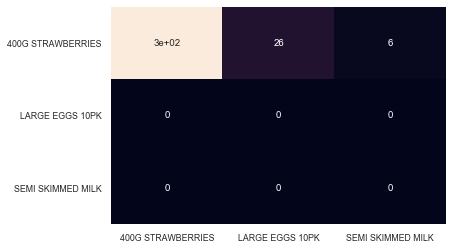

In [136]:
def plotConfusionMatrix(mat):

    # Normalise
    normalized_mat = mat.astype('float') /mat.sum(axis=1)[:, np.newaxis]

    normalized_mat=np.around(normalized_mat*100)
  
    df_cm = pd.DataFrame(mat,index=CLASSES,columns=CLASSES)
    # plt.figure(figsize=(10,7))
    sns.set(font_scale=0.8)  # for label size
    sns.heatmap(df_cm, annot=True, cbar=False)  # font size

    plt.show()
predictions=pred
accuracy = accuracy_score(truth,predictions)
confusion_mat=confusion_matrix(truth,predictions)
precsion, recall, f1_ccore, _ = precision_recall_fscore_support(truth, predictions)
print("Total Test Accuracy :",round(accuracy*100,2))
# print("Precision :", (precsion*100))
# print("Recall :",(recall*100))
# print("F1 score:",f1_ccore*100)

for i in range(0,len(CLASSES)):
    print(CLASSES[i],"Test Accuracy score",round(precsion[i]*100,2))

confusion_mat.shape
plotConfusionMatrix(confusion_mat)


In [137]:


from math import sqrt
def plot_images(images, cls_true, cls_pred=None):

    # Create figure with 3x3 sub-plots.
    count = len(images)
    fig, axes = plt.subplots(int(sqrt(count)), int(sqrt(count)))
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        img = images[i]
        img = np.moveaxis(img,0,-1)   
        ax.imshow(img)


        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def testRandom(model,data_loader,count =4):
    idx=np.random.randint(0,batch_size,count)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
        
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            img_list= np.array(inputs.tolist())[idx]
            predicted_labels=np.array(preds.tolist())[idx]
            true_labels = np.array(labels.tolist())[idx]
          
            break;
 
    # print(imgs.shape)
    # print(preds)
    # print(labels)
   
    
    plot_images(img_list,[CLASSES[x] for x in true_labels],[CLASSES[x] for x in predicted_labels])


   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


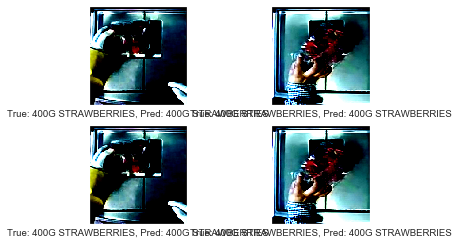

In [138]:
testRandom(model,validation_loader)

In [23]:
my_model = get_pretrained_model()
my_model.load_state_dict(torch.load(save_file_name))

my_model.eval()
my_model
summary(my_model, input_size=(3, 224, 224), batch_size=batch_size)


<All keys matched successfully>

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

In [39]:
from PIL import Image

img = Image.open('train\dog\dog.13.jpg')

img=data_transform(img)
# i=np.asarray(img)

In [40]:
img_tensor=torch.unsqueeze(img,0)

In [41]:
if train_on_gpu:
    img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
else:
    img_tensor = img_tensor.view(1, 3, 224, 224)


In [45]:
with torch.no_grad():
#     model.eval()
    # Model outputs log probabilities
    out = my_model(img_tensor)
    out
    ps = torch.exp(out)
    ps
    _, pred = torch.max(ps, dim=1)
    print(dataset.class_to_idx)
    pred.item()
    
   


tensor([[-5.1596, -0.0058]], device='cuda:0')

tensor([[0.0057, 0.9943]], device='cuda:0')

{'cat': 0, 'dog': 1}


1